In [10]:
import os
import numpy as np
import re
import json 
from PIL import Image

from transformers import ElectraTokenizerFast, VisionTextDualEncoderModel,VisionTextDualEncoderProcessor, ViTFeatureExtractor
import torch
from torchvision.datasets import Flickr30k
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch.nn as nn

In [2]:
from dataloader import get_dataloader


In [3]:
batch_size = 2
shuffle_img = False
num_workers = 2
split = "train"


dataloader_train = get_dataloader(batch_size=batch_size,shuffle=shuffle_img,num_workers=num_workers,split=split)

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [8]:
from transformers import BertModel, BertConfig, BertForQuestionAnswering

In [5]:
config = BertConfig()
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [6]:
model = BertModel.from_pretrained("prajjwal1/bert-medium")

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
print(model.config)

BertConfig {
  "_name_or_path": "prajjwal1/bert-medium",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [9]:
model2 = BertForQuestionAnswering.from_pretrained("prajjwal1/bert-medium")
print(model2.config)

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the mod

BertConfig {
  "_name_or_path": "prajjwal1/bert-medium",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Text Model

In [12]:
import config as CFG
from transformers import BertModel, BertConfig, BertForQuestionAnswering

In [13]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_model_name, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = BertModel.from_pretrained(model_name)
        else:

            self.model = BertModel(config=BertConfig.from_pretrained(model_name))
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Image Model

In [14]:
from transformers import ViTModel, ViTConfig

In [15]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name=CFG.vision_model_name, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = ViTModel.from_pretrained(model_name)
        else:
            self.model = ViTModel(config=ViTConfig.from_pretrained(model_name))
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        

    def forward(self, image):
        
        return self.model(image)

## Projection Head

In [16]:
print(ViTConfig.from_pretrained("facebook/dino-vits16"))

ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0"
}



In [109]:
model_vision_name = "facebook/dino-vits16"
model_text_name = "google/electra-small-discriminator"

tokenizer = ElectraTokenizerFast.from_pretrained(model_text_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_vision_name)

processor = VisionTextDualEncoderProcessor(feature_extractor,tokenizer)

loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/vocab.txt from cache at /home/vincent/.cache/huggingface/transformers/ece45ade3e01224cf31fed8e183b306d17b84e8abd415363474cfe72274f7814.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/tokenizer.json from cache at /home/vincent/.cache/huggingface/transformers/92992b36de47dee64b1d5a31c05d8d51e3075b918a218f5ba4f6e306c4b81b8c.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/tokenizer_config.json from cache at /home/vincent/.cache/huggingface/transformers/8b3aea9f7242b

In [110]:
model = VisionTextDualEncoderModel.from_vision_text_pretrained(model_vision_name,model_text_name)

loading configuration file https://huggingface.co/facebook/dino-vits16/resolve/main/config.json from cache at /home/vincent/.cache/huggingface/transformers/68de969c9d160f14bf2609585daec0b4a44acfb4c88e0092f7a0ae9830bfdbe5.f821792d5923157e75f21eb3c0eedae6b2132114b8142e8bd70be4fb710966e6
Model config ViTConfig {
  "_name_or_path": "facebook/dino-vits16",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0"
}

loading weights file https://huggingface.co/facebook/dino-vits16/resolve/main/pytorch_model.bin from cache at /home/vincent/.cache/huggingface/transformers

## Data

In [112]:
transform = transforms.Compose([
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

In [114]:
batch_size = 2
shuffle_img = False
num_workers = 2


In [115]:
def pre_caption(caption,max_words=128):
    caption = re.sub(
        r"([.!\"()*#:;~])",       
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
            
    return caption

In [116]:
class flickr30k_train(Dataset):
    def __init__(self, transform, image_root, ann_root, max_words=128, prompt=''):        
        '''
        image_root (string): Root directory of images (e.g. data/)
        ann_root (string): directory to store the annotation file
        '''        
        url = 'https://storage.googleapis.com/sfr-vision-language-research/datasets/flickr30k_train.json'
        filename = 'flickr30k_train.json'

        download_url(url,ann_root)
        
        self.annotation = json.load(open(os.path.join(ann_root,filename),'r'))
        self.transform = transform
        self.image_root = image_root
        self.max_words = max_words      
        self.prompt = prompt
        
        self.img_ids = {}  
        n = 0
        for ann in self.annotation:
            img_id = ann['image_id']
            if img_id not in self.img_ids.keys():
                self.img_ids[img_id] = n
                n += 1    
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self, index):    
        
        ann = self.annotation[index]
        
        image_path = os.path.join(self.image_root,ann['image'])        
        image = Image.open(image_path).convert('RGB')   
        image = self.transform(image)
        
        caption = self.prompt+pre_caption(ann['caption'], self.max_words) 

        #return image, caption, self.img_ids[ann['image_id']] 
        return caption, image

In [117]:
ds = flickr30k_train(transform=transform,image_root="",ann_root="./flickr30k")

Using downloaded and verified file: ./flickr30k/flickr30k_train.json


In [118]:
def collate_fn(batch):
    #imgs = torch.stack([item[0] for item in batch])
    caps = [item[0] for item in batch]
    imgs = [item[1] for item in batch]
    #for img, cap in batch:
    
    #    x.append(x_)
    #    caps.append(cap)
    return caps, imgs

In [119]:
dataloader = DataLoader(ds,batch_size=batch_size,shuffle=shuffle_img,collate_fn=collate_fn)

In [120]:
caps,imgs = next(iter(dataloader))

In [128]:
caps

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young, white males are outside near many bushes']

In [130]:
temp = ["./flickr30k-images/36979.jpg","./flickr30k-images/65567.jpg"]
imgs_test = [Image.open(path) for path in temp]

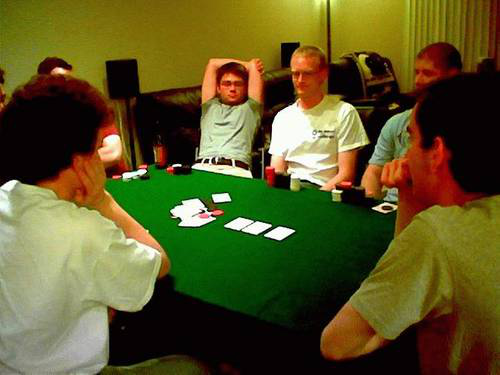

In [134]:
imgs_test[0]

In [143]:
cap_test = ["a test", "second test which is longer"]

In [144]:
test_inputs = processor(cap_test,imgs_test,return_tensors="pt",padding=True)

In [145]:
test_inputs

{'input_ids': tensor([[ 101, 1037, 3231,  102,    0,    0,    0],
        [ 101, 2117, 3231, 2029, 2003, 2936,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]]), 'pixel_values': tensor([[[[-0.7650, -0.7822, -0.6965,  ..., -0.6965, -0.7650, -0.9705],
          [-0.7479, -0.7137, -0.6965,  ..., -0.6452, -0.7479, -0.9877],
          [-0.7479, -0.7137, -0.6623,  ..., -0.5938, -0.7137, -0.9192],
          ...,
          [-0.1314, -0.1828, -0.0972,  ..., -0.9363, -0.9534, -0.7822],
          [-0.1828, -0.0801, -0.0801,  ..., -0.9363, -0.9020, -0.7308],
          [-0.0972,  0.0569,  0.0056,  ..., -0.8849, -0.7479, -0.6965]],

         [[-0.4601, -0.5301, -0.5301,  ..., -1.5980, -1.6856, -1.8957],
          [-0.4251, -0.4601, -0.5476,  ..., -1.5980, -1.7206, -1.9482],
          [-0.4426, -0.4776, -0.4951,  ..., -1.6155, -1.7381, -1.9307],
          ...,
          [ 0.0126, 

In [146]:
inputs = processor(text=caps,images=imgs, return_tensors="pt", padding=True)


In [147]:
print(inputs.input_ids.shape)
print(test_inputs.input_ids.shape)

torch.Size([2, 18])
torch.Size([2, 7])


In [148]:
print(inputs.attention_mask.shape)
print(test_inputs.attention_mask.shape)

torch.Size([2, 18])
torch.Size([2, 7])


In [149]:
print(inputs.pixel_values.shape)
print(test_inputs.pixel_values.shape)

torch.Size([2, 3, 224, 224])
torch.Size([2, 3, 224, 224])


In [150]:
inputs.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [151]:
inputs.pixel_values.shape

torch.Size([2, 3, 224, 224])

In [152]:
outputs = model(
    input_ids=test_inputs.input_ids,
    attention_mask=test_inputs.attention_mask,
    pixel_values=test_inputs.pixel_values,
    return_loss=True,
)

IndexError: tuple index out of range

In [122]:
outputs = model(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    pixel_values=inputs.pixel_values,
    return_loss=True,
)

IndexError: tuple index out of range